# Importing Libraries

In [1]:
import numpy as np, pandas as pd

!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 655.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 15.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 31.3 MB/s eta 0:00:00
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=6b74c3f8f614834eca6238b296041fc003d6909c9f66a7389fad1db5eb6fdcea
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
Successfully built chances
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninst

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# Importing Data

In [2]:
train = pd.read_csv('../input/dataset/train.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test = pd.read_csv('../input/dataset/test.csv')

In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Data Exploration

Checking for missing values

In [6]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [7]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [8]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

# Data Pre-processing

**Text Normalization**
* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [9]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],
    ' adolf ':
        [
            'adolf'
        ],
    ' hitler ':
        [
            'hitler'
        ],
    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\\$%\\^\\&\\*]*u[!@#\\$%\\^&\\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\\*\\*', 'f**k', 'fu*k',
            'f\\-ing', 'f\\.u\\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],
    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\\$\\$',
            '[^a-z]anus', ' a\\*s\\*s', '[^a-z]ass[^a-z ]',
            'a[@#\\$%\\^&\\*][@#\\$%\\^&\\*]', '[^a-z]anal ', 'a s s', 'a55', '@$$'
        ],
    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\\$\\$hole', 'a**hole'
        ],
    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\\+ch', 'b!\\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\\*\\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],
    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],
    ' trans gender':
        [
            'transgender'
        ],
    ' gay ':
        [
            'gay'
        ],
    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],
    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],
    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],
    ' cunt ':
        [
            'cunt', 'c u n t'
        ],
    ' bull shit ':
        [
            'bullsh\\*t', 'bull\\$hit'
        ],
    ' homo sex ual':
        [
            'homosexual'
        ],
    ' jerk ':
        [
            'jerk'
        ],
    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],
    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],
    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\\$hit', 's h i t', '$h1t'
        ],
    ' shit hole ':
        [
            'shythole'
        ],
    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],
    ' rape ':
        [
            ' raped'
        ],
    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],
    ' ass head':
        [
            'butthead'
        ],
    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],
    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],
    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],
    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],
    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],
    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],
    ' whore ':
        [
            'wh\\*\\*\\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}

In [10]:
def clean_text(text, remove_repeat_text=True, remove_patterns_text=True, is_lower=True):
    if is_lower:
        text = text.lower()

    if remove_patterns_text:
        for target, patterns in RE_PATTERNS.items():
            for pat in patterns:
                text = str(text).replace(pat, target)

    if remove_repeat_text:
        text = re.sub(r'(.)\1{2,}', r'\1', text)

    text = str(text).replace("\n", " ")
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub('[0-9]', "", text)
    text = re.sub(" +", " ", text)
    text = re.sub("([^\x00-\x7F])+", " ", text)
    return text

**Cleaning Training Data**

In [11]:
train['comment_text'] = train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

**Cleaning Test Data**

In [12]:
test['comment_text'] = test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'this is a university ip address just fyi '

# Lemmatization

In [13]:
comments_train = train['comment_text']
comments_test = test['comment_text']

In [14]:
comments_train = list(comments_train)
comments_test = list(comments_test)

In [15]:
wordnet_lemmatizer = WordNetLemmatizer()

In [16]:
def lemma(text, lemmatization=True):
    output = ""
    if lemmatization:
        text = text.split(" ")
        for word in text:
            word1 = wordnet_lemmatizer.lemmatize(word, pos="n")
            word2 = wordnet_lemmatizer.lemmatize(word1, pos="v")
            word3 = wordnet_lemmatizer.lemmatize(word2, pos="a")
            word4 = wordnet_lemmatizer.lemmatize(word3, pos="r")
            output = output + " " + word4
    else:
        output = text

    return str(output.strip())

**Lemmatizing Training Data**

In [17]:
lemmatized_train_data = []

for line in tqdm_notebook(comments_train, total=159571):
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [18]:
lemmatized_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

**Lemmatizing Test Data**

In [19]:
lemmatized_test_data = []

for line in tqdm_notebook(comments_test, total=len(comments_test)):
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

# Stopwords Removal

In [20]:
stopword_list = STOP_WORDS

**Adding Single and Dual to STOP_WORDS**

In [21]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list = []

for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [22]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [23]:
for letter in dual_alpha_list:
    stopword_list.add(letter)

**Checking for other words that we may need in STOP_WORDS**

In [24]:
def search_stopwords(data, search_stop=True):
    output = ""
    if search_stop:
        data = data.split(" ")
        for word in data:
            if word not in stopword_list:
                output = output + " " + word
    else:
        output = data

    return str(output.strip())

In [25]:
potential_stopwords = []

for line in tqdm_notebook(lemmatized_train_data, total=159571):
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [26]:
len(potential_stopwords)

159571

**Combining all the sentences in the list into a single string**

In [27]:
def string_combine_a(stopword):
    final_a = ""
    for item in range(39893):
        final_a = final_a + " " + stopword[item]
    return final_a

def string_combine_b(stopword):
    final_b = ""
    for item in range(39893, 79785):
        final_b = final_b + " " + stopword[item]
    return final_b

def string_combine_c(stopword):
    final_c = ""
    for item in range(79785, 119678):
        final_c = final_c + " " + stopword[item]
    return final_c

def string_combine_d(stopword):
    final_d = ""
    for item in range(119678, 159571):
        final_d = final_d + " " + stopword[item]
    return final_d

In [28]:
total_string_potential_a = string_combine_a(potential_stopwords)
total_string_potential_b = string_combine_b(potential_stopwords)
total_string_potential_c = string_combine_c(potential_stopwords)
total_string_potential_d = string_combine_d(potential_stopwords)

**Counting the number of words in each of the 4 strings**

In [29]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [30]:
total_string_potential_a_dict = word_count(total_string_potential_a)
total_string_potential_b_dict = word_count(total_string_potential_b)
total_string_potential_c_dict = word_count(total_string_potential_c)
total_string_potential_d_dict = word_count(total_string_potential_d)

**Converting Dictionaries to Dataframe**

In [31]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()), columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()), columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()), columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()), columns = ['Word','Count'])

**Getting Dataframe output in descending order**

In [32]:
top50_potential_stopwords_a = total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b = total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c = total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d = total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

**Looking for common terms in all top 50 dataframes**

In [33]:
common_potential_stopwords = list(reduce(set.intersection, map(set, [top50_potential_stopwords_a.Word, top50_potential_stopwords_b.Word, top50_potential_stopwords_c.Word, top50_potential_stopwords_d.Word])))

In [34]:
print(common_potential_stopwords)

['link', 'want', 'need', 'thank', 'deletion', 'change', 'block', 'new', 'work', 'know', 'comment', 'good', 'like', 'look', 'wikipedia', 'image', 'help', 'talk', 'delete', 'thing', 'time', 'user', 'find', 'think', 'fuck', 'point', 'editor', 'people', 'source', 'article', 'mean', 'page', 'question', 'reference', 'fact', 'edit', 'section', 'information', 'use', 'doe', 'try', 'list', 'add', 'way', 'don', 'read', 'remove', 'write']


**Retaining certain words and removing others from the above list**

In [35]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

**Adding above retrived words into the stopwords list**

In [36]:
for word in potential_stopwords:
    stopword_list.add(word)

**Removing Stopwords from Training Data**

In [37]:
def remove_stopwords(text, remove_stop=True):
    output = ""
    if remove_stop:
        text = text.split(" ")
        for word in text:
            if word not in stopword_list:
                output = output + " " + word
    else:
        output = text

    return str(output.strip())

In [38]:
processed_train_data = []

for line in tqdm_notebook(lemmatized_train_data, total=159571):
    processed_train_data.append(remove_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [39]:
processed_train_data[152458]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

**Removing Stopwords from Test Data**

In [40]:
processed_test_data = []

for line in tqdm_notebook(lemmatized_test_data, total=153164):
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

# Model Building

In [41]:
max_features = 100000
maxpadlen = 200
val_split = 0.2
embedding_dim_fasttext = 300

**Tokenization**

In [42]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [43]:
word_index = tokenizer.word_index
print("Words in Vocabulary: ", len(word_index))

Words in Vocabulary:  148917


**Padding**

In [44]:
X_t = pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding='post')
X_te = pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding='post')

In [45]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [46]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [47]:
X_t = X_t[indices]
labels = y[indices]

# Splitting data into Training and Validation Set

In [48]:
num_validation_samples = int(val_split * X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [49]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12293  1296  6771   374  6356  1142]
validation:  [3001  299 1678  104 1521  263]


# Importing Fast Text

In [50]:
embeddings_index_fasttext = {}
f = open('../input/dataset/wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [51]:
embedding_matrix_fasttext = np.random.random(
    (len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector

# Creating Model

**Talos Grid Search for LSTM Model**

In [52]:
def toxic_classifier(x_train, y_train, x_val, y_val, params):
    inp = Input(shape=(maxpadlen, ), dtype='int32')
    embedding_layer = Embedding(len(word_index) + 1, embedding_dim_fasttext, weights=[embedding_matrix_fasttext], input_length=maxpadlen, trainable=False, name='embeddings')
    embedded_sequences = embedding_layer(inp)

    x = LSTM(params['output_count_lstm'], return_sequences=True, name='lstm_layer')(embedded_sequences)
    x = GlobalMaxPool1D()(x)
    x = Dropout(params['dropout'])(x)
    x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
    x = Dropout(params['dropout'])(x)

    preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)
    model = Model(inputs=inp, outputs=preds)

    model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])
    model_info = model.fit(x_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(x_val, y_val))
    
    return model_info, model

In [53]:
p = {
    'output_count_lstm': [40, 50, 60],
    'output_count_dense': [30, 40, 50],
    'batch_size': [32],
    'epochs': [2],
    'optimizer': ['adam'],
    'activation': ['relu'],
    'last_activation': ['sigmoid'],
    'dropout': [0.1, 0.2],
    'loss': ['binary_crossentropy']
}

In [54]:
scan_results = talos.Scan(x=x_train,
                          y=y_train,
                          x_val=x_val,
                          y_val=y_val,
                          model=toxic_classifier,
                          params=p,
                          experiment_name='tcc',
                          print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}


2022-08-31 03:30:38.803203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 03:30:38.804371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 03:30:38.805038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-31 03:30:38.805825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/2


2022-08-31 03:30:50.490552: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3990/3990 [==============================] - 46s 11ms/step - loss: 0.0696 - accuracy: 0.9025 - val_loss: 0.0504 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0498 - accuracy: 0.9841 - val_loss: 0.0481 - val_accuracy: 0.9934


2022-08-31 03:33:11.521359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 178701600 exceeds 10% of free system memory.
  6%|▌         | 1/18 [02:33<43:33, 153.71s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}


2022-08-31 03:33:12.693372: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 178701600 exceeds 10% of free system memory.
2022-08-31 03:33:13.276627: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 102125600 exceeds 10% of free system memory.


Epoch 1/2
3990/3990 [==============================] - 43s 10ms/step - loss: 0.0688 - accuracy: 0.9018 - val_loss: 0.0508 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0523 - accuracy: 0.9905 - val_loss: 0.0487 - val_accuracy: 0.9936


 11%|█         | 2/18 [04:58<39:38, 148.65s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0626 - accuracy: 0.9619 - val_loss: 0.0491 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0494 - accuracy: 0.9897 - val_loss: 0.0502 - val_accuracy: 0.9933


 17%|█▋        | 3/18 [07:23<36:43, 146.87s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0675 - accuracy: 0.9236 - val_loss: 0.0508 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0518 - accuracy: 0.9938 - val_loss: 0.0500 - val_accuracy: 0.9936


 22%|██▏       | 4/18 [09:48<34:06, 146.21s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0629 - accuracy: 0.9325 - val_loss: 0.0501 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 41s 10ms/step - loss: 0.0495 - accuracy: 0.9787 - val_loss: 0.0482 - val_accuracy: 0.9932


 28%|██▊       | 5/18 [12:13<31:35, 145.81s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 43s 11ms/step - loss: 0.0662 - accuracy: 0.9317 - val_loss: 0.0495 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0505 - accuracy: 0.9882 - val_loss: 0.0478 - val_accuracy: 0.9931


 33%|███▎      | 6/18 [14:38<29:06, 145.52s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0654 - accuracy: 0.9162 - val_loss: 0.0503 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0504 - accuracy: 0.9856 - val_loss: 0.0477 - val_accuracy: 0.9936


 39%|███▉      | 7/18 [17:03<26:38, 145.35s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0690 - accuracy: 0.9175 - val_loss: 0.0513 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0523 - accuracy: 0.9914 - val_loss: 0.0486 - val_accuracy: 0.9936


 44%|████▍     | 8/18 [18:40<21:37, 129.76s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0638 - accuracy: 0.9232 - val_loss: 0.0496 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0493 - accuracy: 0.9716 - val_loss: 0.0472 - val_accuracy: 0.9936


 50%|█████     | 9/18 [20:17<17:55, 119.47s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0659 - accuracy: 0.9360 - val_loss: 0.0502 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0512 - accuracy: 0.9896 - val_loss: 0.0491 - val_accuracy: 0.9936


 56%|█████▌    | 10/18 [22:41<16:58, 127.29s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0599 - accuracy: 0.9389 - val_loss: 0.0487 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 47s 12ms/step - loss: 0.0485 - accuracy: 0.9829 - val_loss: 0.0466 - val_accuracy: 0.9931


 61%|██████    | 11/18 [24:19<13:46, 118.08s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0635 - accuracy: 0.9307 - val_loss: 0.0517 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 46s 12ms/step - loss: 0.0508 - accuracy: 0.9813 - val_loss: 0.0477 - val_accuracy: 0.9936


 67%|██████▋   | 12/18 [25:55<11:08, 111.49s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0624 - accuracy: 0.9161 - val_loss: 0.0493 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0491 - accuracy: 0.9800 - val_loss: 0.0482 - val_accuracy: 0.9936


 72%|███████▏  | 13/18 [28:20<10:08, 121.71s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0666 - accuracy: 0.8943 - val_loss: 0.0511 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0518 - accuracy: 0.9818 - val_loss: 0.0488 - val_accuracy: 0.9934


 78%|███████▊  | 14/18 [29:52<07:31, 112.81s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0623 - accuracy: 0.9335 - val_loss: 0.0499 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0485 - accuracy: 0.9884 - val_loss: 0.0481 - val_accuracy: 0.9933


 83%|████████▎ | 15/18 [31:25<05:20, 106.75s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0653 - accuracy: 0.9268 - val_loss: 0.0506 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0505 - accuracy: 0.9689 - val_loss: 0.0489 - val_accuracy: 0.9936


 89%|████████▉ | 16/18 [32:57<03:24, 102.28s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0617 - accuracy: 0.9647 - val_loss: 0.0505 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 45s 11ms/step - loss: 0.0499 - accuracy: 0.9894 - val_loss: 0.0481 - val_accuracy: 0.9934


 94%|█████████▍| 17/18 [35:23<01:55, 115.31s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0637 - accuracy: 0.9393 - val_loss: 0.0508 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0512 - accuracy: 0.9868 - val_loss: 0.0478 - val_accuracy: 0.9936


100%|██████████| 18/18 [36:55<00:00, 123.11s/it]


In [55]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

1

In [56]:
analyze_object = talos.Analyze(scan_results)

In [57]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[2, 50, 32, '08/31/22-035055', 'relu', 40, 'adam', 'sigmoid', 2,
        143.90927290916443, '08/31/22-035319', 0.2, 0],
       [2, 50, 32, '08/31/22-034742', 'relu', 30, 'adam', 'sigmoid', 2,
        95.25490164756775, '08/31/22-034917', 0.2, 1],
       [2, 60, 32, '08/31/22-040204', 'relu', 40, 'adam', 'sigmoid', 2,
        91.05259084701538, '08/31/22-040335', 0.2, 2],
       [2, 60, 32, '08/31/22-035634', 'relu', 30, 'adam', 'sigmoid', 2,
        144.34477496147156, '08/31/22-035858', 0.1, 3],
       [2, 50, 32, '08/31/22-035457', 'relu', 50, 'adam', 'sigmoid', 2,
        95.33320713043213, '08/31/22-035633', 0.2, 4],
       [2, 40, 32, '08/31/22-033312', 'relu', 30, 'adam', 'sigmoid', 2,
        144.24096512794495, '08/31/22-033536', 0.2, 5],
       [2, 50, 32, '08/31/22-034918', 'relu', 40, 'adam', 'sigmoid', 2,
        95.5694272518158, '08/31/22-035054', 0.1, 6],
       [2, 60, 32, '08/31/22-040601', 'relu', 50, 'adam', 'sigmoid', 2,
        91.96979475021362, '08/31/22-

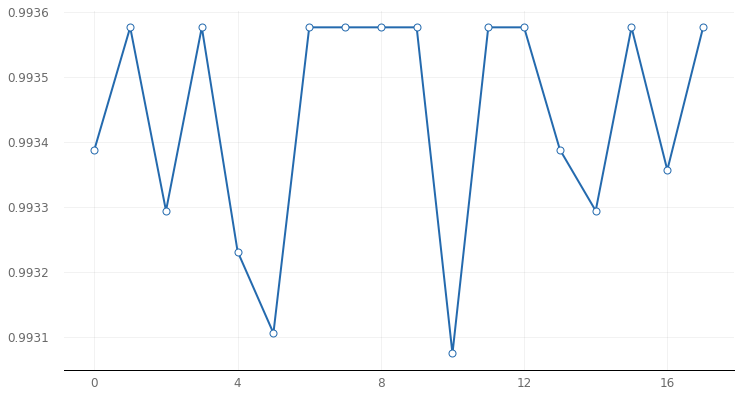

In [58]:
analyze_object.plot_line('val_accuracy')

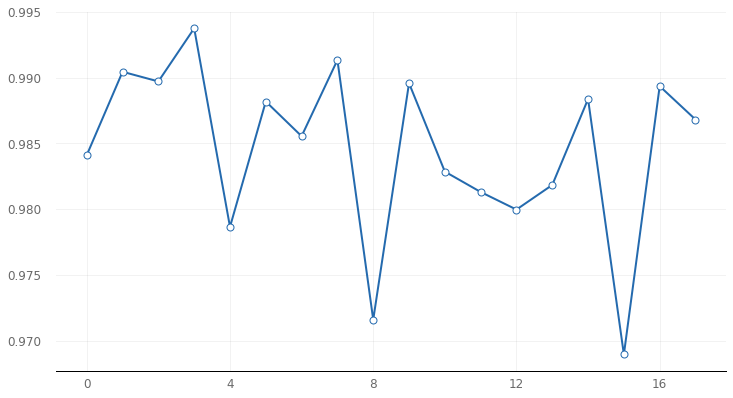

In [59]:
analyze_object.plot_line('accuracy')

# Training Model with Best Parameters

In [60]:
inp = Input(shape=(maxpadlen, ), dtype='int32')

In [61]:
embedding_layer = Embedding(len(word_index) + 1, embedding_dim_fasttext, weights=[embedding_matrix_fasttext], input_length=maxpadlen, trainable=False, name='embeddings')
embedded_sequences = embedding_layer(inp)

In [62]:
x = LSTM(40, return_sequences=True, name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [63]:
model = Model(inputs=inp, outputs=preds)
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [64]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 300)          44675400  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 40)           54560     
_________________________________________________________________
global_max_pooling1d (Global (None, 40)                0         
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 30)                1230      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0     

In [65]:
model_info = model.fit(x_train, y_train, epochs=2, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 44s 11ms/step - loss: 0.0655 - accuracy: 0.9091 - val_loss: 0.0503 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 42s 10ms/step - loss: 0.0502 - accuracy: 0.9895 - val_loss: 0.0474 - val_accuracy: 0.9936


# Plotting Graphs

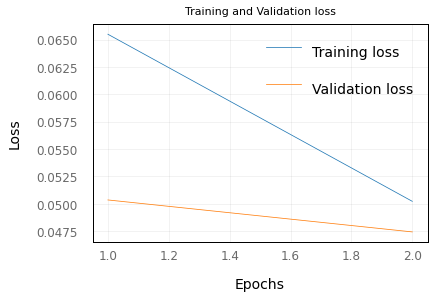

In [66]:
loss = model_info.history['loss']
val_loss = model_info.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

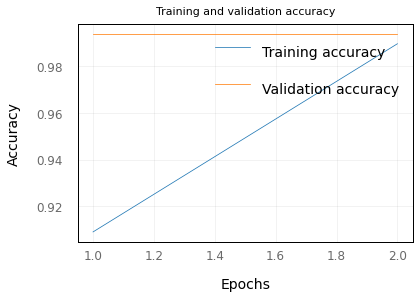

In [67]:
accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

accuracy = model_info.history['accuracy']
val_accuracy = model_info.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Saving the Model

In [68]:
model.save(filepath="model.h5")

# Loading Saved Model

In [69]:
loaded_model = keras.models.load_model(filepath="model.h5")

# Testing the Created Model

In [70]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    prediction = model.predict(new_string)

    print("Toxicity levels:".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()

    return

In [71]:
toxicity_level('go jump off a bridge jerk')

Toxicity levels:
Toxic:         72%
Severe Toxic:  1%
Obscene:       30%
Threat:        1%
Insult:        37%
Identity Hate: 1%



In [72]:
toxicity_level('i will kill you')

Toxicity levels:
Toxic:         16%
Severe Toxic:  0%
Obscene:       2%
Threat:        2%
Insult:        5%
Identity Hate: 0%



In [73]:
toxicity_level('have a nice day')

Toxicity levels:
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [74]:
toxicity_level('fuck ofF!!')

Toxicity levels:
Toxic:         99%
Severe Toxic:  18%
Obscene:       95%
Threat:        3%
Insult:        78%
Identity Hate: 3%



In [75]:
toxicity_level('Hello, How are you?')

Toxicity levels:
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [76]:
toxicity_level('get the fuck away from me @sshole!!')

Toxicity levels:
Toxic:         95%
Severe Toxic:  8%
Obscene:       89%
Threat:        2%
Insult:        62%
Identity Hate: 2%

